In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.stationary_iso import(
    StationaryIso, # general solution
    StationaryIsoNoDissipation, # analytical solution for testing case without dissipation
)

# Isotropic scattering under stationary conditions
General solution
\begin{align}
\textbf{E}&=\sum_{i=1}^2c_i\textrm{e}^{\lambda_i (x-x_i)}\textbf{v}_i
\end{align}
Boundary conditions:
\begin{align}
1&=\sum_{i=0}^1c_i\textrm{e}^{-\lambda_i x_i}\textbf{v}_{i0}\\
0&=\sum_{i=0}^1c_i\textrm{e}^{\lambda_i (w-x_i)}\textbf{v}_{i1}
\end{align}

## Solve and test the boundary conditions
### No dissipation
- can compare numerical and analytic solutions

In [2]:
def test_bdy_cons(sa):
    x = np.array([0., sa.w])
    ep, em = sa.calc_expansion(x)
    print(f'E_+(0) = 1? {ep[0]}')
    print(f'E_-(w) = 0? {em[1]}')
    print(f'E_+(w) = {ep[1]}')
    print(f'E_-(0) = {em[0]}')

In [3]:
sa = StationaryIso(eps=1e-8)
test_bdy_cons(sa)

E_+(0) = 1? 1.0
E_-(w) = 0? 0.0
E_+(w) = 0.999999999
E_-(0) = 0.0


In [4]:
sa0 = StationaryIsoNoDissipation()
test_bdy_cons(sa0)

E_+(0) = 1? 1.0
E_-(w) = 0? 0.0
E_+(w) = 1.0
E_-(0) = 0.0


In [5]:
x = np.array([0., sa.w])
sa0.calc_wave_stress(x)

array([0., 0.])

In [6]:
sa.calc_wave_stress(x)

array([1.00000000e-08, 9.99999999e-09])

### With dissipation
- only numerical solution

In [7]:
sa = StationaryIso(eps=2)
test_bdy_cons(sa)

E_+(0) = 1? 1.0
E_-(w) = 0? 0.0
E_+(w) = 0.8187307530779818
E_-(0) = 0.0


## Plots to see effect of $\beta$ without dissipation
Also look at convergence to the wide-MIZ asymptote

In [8]:
def plot_energy(cls, x, plot_var='E', ax=None, legend_text=None, log_scale=False, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    sa = cls(**kwargs)
    ep, em = sa.calc_expansion(x)
    if plot_var == "E":
        y = ep + em
    else:
        assert(plot_var == "\delta")
        y = ep - em
    ax.plot(x, y, label=legend_text)
    ax.set_xlabel('$x$')
    ax.set_ylabel(f'${plot_var}$')
    if log_scale:
        ax.set_yscale('log')
    return ax

In [9]:
def plot_one_panel(w, log_scale, eps=0., plot_var='E', title=None,
                   add_asymptote=True, ax=None, add_legend=True):
    x = np.linspace(0, w, 50)
    for b in [-.8, -.4, 0, .4, .8]:
        ax = plot_energy(StationaryAniso, x,
                         ax=ax, beta=b, w=w,
                         eps=eps, plot_var=plot_var,
                         legend_text=f"{b}",
                         log_scale=log_scale,
                        )
    if title is None:
        title = f'w=${w}$'
    ax.set_title(title)
    if add_asymptote:
        ax.plot(x, 2 * np.exp(-x), ':k', label='$w=\infty$')
    if add_legend:
        ax.legend()
    return ax

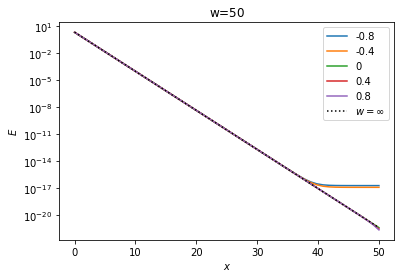

In [10]:
w, log_scale, add_asym = 50, True, True
# w, log_scale, add_asym = 10, True, True
# w, log_scale, add_asym = 7, True, True
# w, log_scale, add_asym = 5, True, True
# w, log_scale, add_asym = 3, False, True
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym)

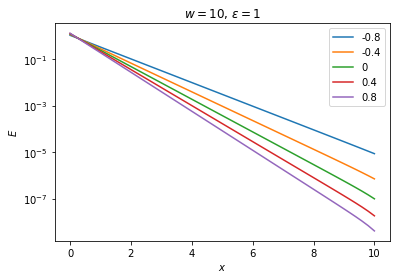

In [11]:
# w, eps, log_scale, add_asym = 3, 1, False, False
w, eps, log_scale, add_asym = 10, 1, True, False
title = fr'$w={w}$, $\varepsilon={eps}$'
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym,
                    eps=1, plot_var='E', title=title)

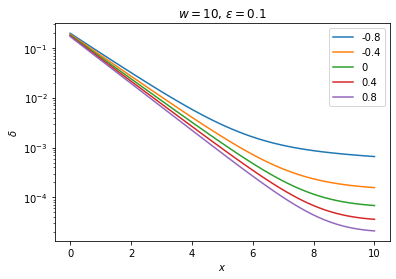

In [12]:
# w, eps, log_scale, add_asym = 3, .1, False, False
w, eps, log_scale, add_asym = 10, .1, True, False
title = fr'$w={w}$, $\varepsilon={eps}$'
ax = plot_one_panel(w, log_scale, add_asymptote=add_asym,
                    eps=0.1, plot_var='\delta', title=title)

In [13]:
def get_energy_fig(eps=0, add_asyms=True):
    fig, axs = plt.subplots(1, 4)
    ws = [1, 2, 5, 10] # width
    lss = [False, False, True, True] #log scale
    if add_asyms:
        aas = [False, True, True, True] # add wide MIZ asymptote
    else:
        aas = 4 * [False]
    for i, (ax, w, log_scale, add_asym) in enumerate(
        zip(axs, ws, lss, aas)):
        ax = plot_one_panel(w, log_scale, ax=ax,
                            eps=eps, plot_var='E',
                            add_asymptote=add_asym,
                            add_legend=(i == len(ws) - 1),
                           )
    fig.tight_layout()
    return fig

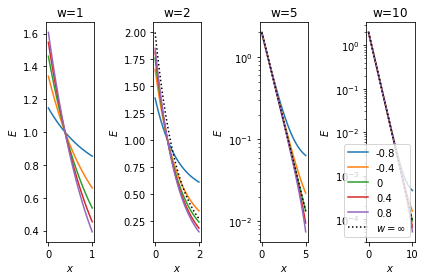

In [14]:
fig = get_energy_fig()
os.makedirs('figs/paper', exist_ok=True)
fig.savefig('figs/paper/energy_w_beta.png')

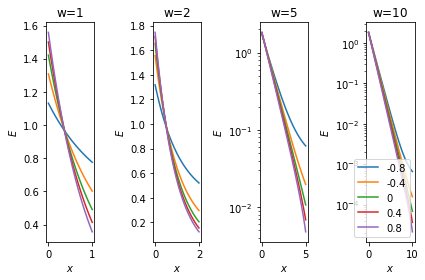

In [15]:
fig = get_energy_fig(eps=.1, add_asyms=False)

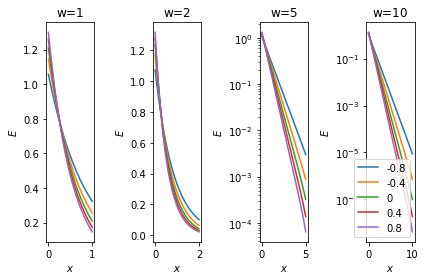

In [16]:
fig = get_energy_fig(eps=1, add_asyms=False)

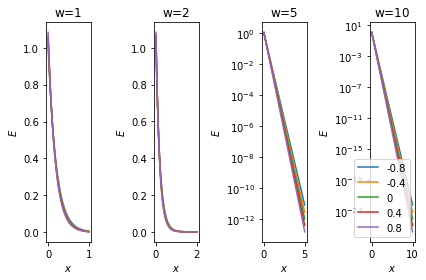

In [17]:
fig = get_energy_fig(eps=5, add_asyms=False)

In [18]:
def get_fig_E_and_delta(w=1, eps=0, log_scale=True):
    """ side by side plots of E and \delta """
    fig, axs = plt.subplots(1, 2)
    for i, (ax, plot_var) in enumerate(
        zip(axs, ['E', '\delta'])):
        title = fr'$w={w}$, $\varepsilon={eps}$'
        ax = plot_one_panel(w, log_scale, ax=ax,
                            eps=eps, plot_var=plot_var,
                            title=title,
                            add_asymptote=False,
                            add_legend=(i == 1),
                           )
    fig.tight_layout()
    return fig

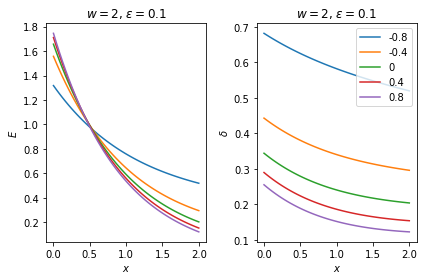

In [19]:
w, eps, log_scale = 2, .1, False
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

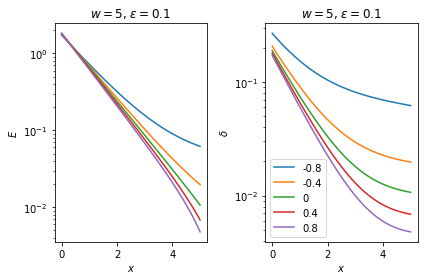

In [20]:
w, eps, log_scale = 5, .1, True
# w, eps, log_scale = 10, .1, True
# w, eps, log_scale = 3, 1, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

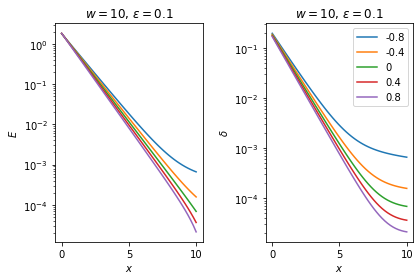

In [21]:
# w, eps, log_scale = 3, .1, False
w, eps, log_scale = 10, .1, True
# w, eps, log_scale = 3, 3, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

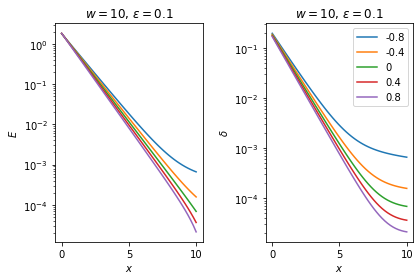

In [22]:
# w, eps, log_scale = 3, .1, False
w, eps, log_scale = 10, .1, True
# w, eps, log_scale = 3, 3, True
_ = get_fig_E_and_delta(w=w, eps=eps, log_scale=log_scale)

In [23]:
def plot_flux(xfac=0, eps=0, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    beta = np.linspace(-1, 1, 50)
    w_all = [1,2,3]
    for w in w_all:
        fluxes = []
        for b in beta:
            sa = StationaryAniso(beta=b, w=w, eps=eps)
            x = np.array([xfac * w])
            ep, em = sa.calc_expansion(x)
            fluxes +=  [ep - em]
        ax.plot(beta, fluxes, label=f'$w={w}$')
    ax.set_xlabel(r'$\beta_{aniso}$')
    ax.set_ylabel(r'$\delta(0)$')
    ax.set_title(fr'$\varepsilon={eps}$')
    ax.legend()
    return ax

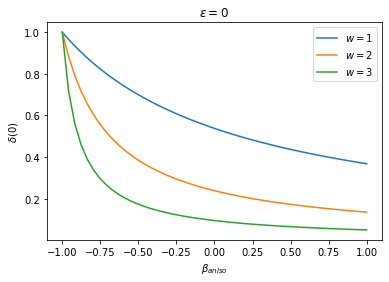

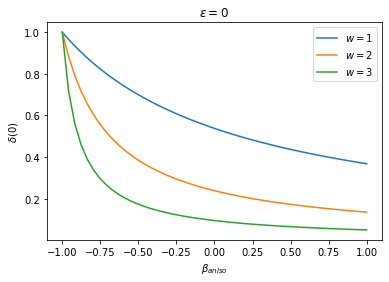

In [24]:
_ = plot_flux()
_ = plot_flux(xfac=1)

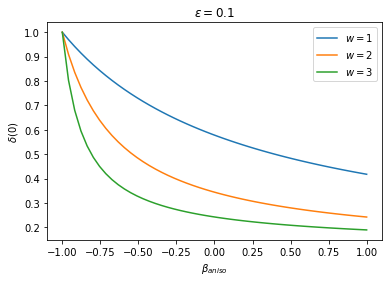

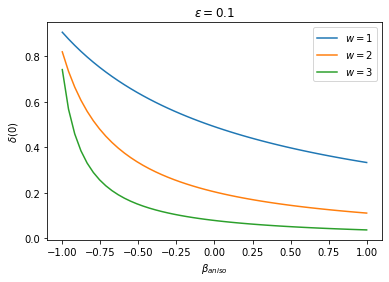

In [25]:
_ = plot_flux(eps=.1)
_ = plot_flux(eps=.1, xfac=1)

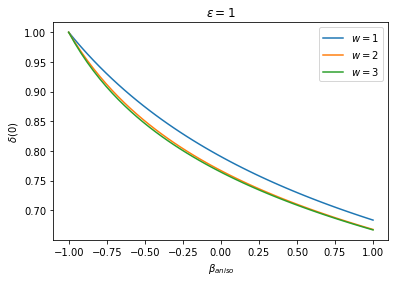

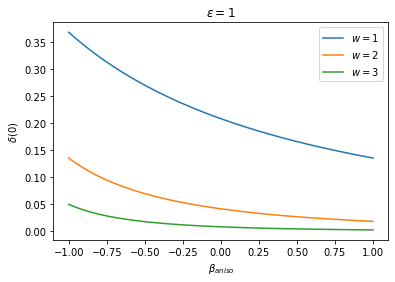

In [26]:
_ = plot_flux(eps=1)
_ = plot_flux(eps=1, xfac=1)

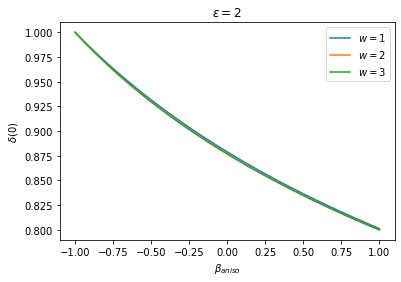

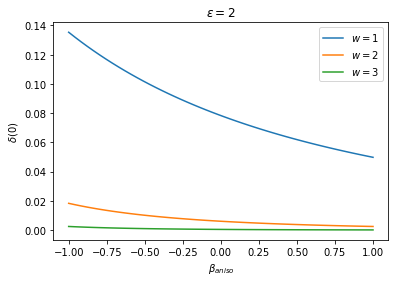

In [27]:
_ = plot_flux(eps=2)
_ = plot_flux(eps=2, xfac=1)

In [28]:
def get_figs_E_and_delta(params):
    """ 
    side by side plots of E and \delta
    
    Parameters:
    -----------
    params : list
        len=2;
        each element is (w,eps,log_scale), with
            w : float
            eps : float
            log_scale : bool
    """
    fig, axs_all = plt.subplots(2, 2)
    assert(len(params) == 2)
    for i, (axs, (w, eps, log_scale)) in enumerate(
        zip(axs_all, params)):
        for j, (ax, plot_var) in enumerate(
            zip(axs, ['E', '\delta'])):
            title = fr'$w={w}$, $\varepsilon={eps}$'
            ax = plot_one_panel(w, log_scale, ax=ax,
                                eps=eps, plot_var=plot_var,
                                title=title,
                                add_asymptote=False,
                                add_legend=(i * j == 1),
                               )
    fig.tight_layout()
    return fig

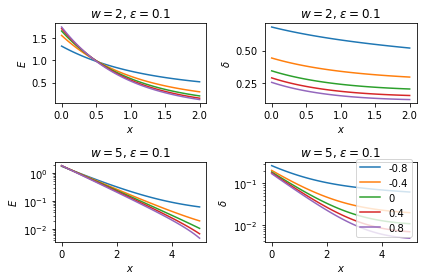

In [29]:
params = [
    (2, .1, False),
    (5, .1, True),
    ]
fig = get_figs_E_and_delta(params)
fig.savefig('figs/paper/energy_and_flux_w_beta_eps.png')